# RANSynCoders 

#### Packages

In [ ]:
import os
import sys
from pathlib import Path
import random

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

In [ ]:
from eval_methods import bf_search, blind_bf_search, calc_twseq, calc_seq
from main import RANSynCoders
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [3]:
os.chdir("/home/maradonam/TAD-main")
print("after: %s"%os.getcwd())

after: /home/maradonam/TAD-main


In [4]:
from utils.data_loader import load_samsung
from utils.evaluator_seg import compute_anomaly_scores, compute_metrics
from tqdm import tqdm
from itertools import groupby
from operator import itemgetter
import simdjson

In [5]:
def _count_anomaly_segments(values):
    values = np.where(values == 1)[0]
    anomaly_segments = []
    
    for k, g in groupby(enumerate(values), lambda ix : ix[0] - ix[1]):
        anomaly_segments.append(list(map(itemgetter(1), g)))
    return len(anomaly_segments), anomaly_segments

## Data Setup - SAMSUNG

In [6]:
data_path = './datasets/samsung/September'
datasets = sorted([f for f in os.listdir(f'{data_path}/train') if os.path.isfile(os.path.join(f'{data_path}/train', f))])
datasets

['A.csv', 'B.csv', 'C.csv']

In [7]:
WAVELET_NUM = 3
ALPHA = -0.7
decomposition=False
segmentation=True

In [8]:
for loader in [load_samsung]:
    datasets = loader(36, 1, ALPHA, WAVELET_NUM, decomposition=decomposition, segmentation=segmentation)
    x_trains, x_tests, y_tests = datasets['x_train'], datasets['x_test'], datasets['y_test']
    y_segment_test = datasets['y_segment_test']
    
    for i in tqdm(range(len(x_trains))):
        X_train = x_trains[i]
        X_test = x_tests[i]
        
        if i ==0:
            print(X_train.shape)

100%|██████████| 3/3 [00:00<00:00, 5043.25it/s]

(21511, 36, 8)


In [9]:
data_path = './datasets/samsung/September'
datasets = sorted([f for f in os.listdir(f'{data_path}/train') if os.path.isfile(os.path.join(f'{data_path}/train', f))])

x_train, x_test, y_test = [], [], []
y_segment_test = []
x_train_scaled, x_test_scaled = [], []

seg_scores = {'dataset': [], 'avg_f1': [], 'avg_p': [], 'avg_r': [], 'max_p': [], 'max_r': [],  'max_f1': [], 'correct_count': [], 'correct_ratio': []}
for data in tqdm(datasets):
    train_df = pd.read_csv(f'{data_path}/train/{data}', index_col=[0])
    train_df = train_df.iloc[:,:-1]
    train_df.reset_index(inplace=True, drop=True)
    
    test_df = pd.read_csv(f'{data_path}/test/{data}', index_col=[0])
    test_df = test_df.iloc[:,:-1]
    test_df.reset_index(inplace=True, drop=True)
    
    labels =  pd.read_csv(f'{data_path}/test/{data}', index_col=[0])
    labels = labels.iloc[:, -1]
    labels.reset_index(inplace=True, drop=True)
    
    t_train = np.tile(train_df.index.values.reshape(-1,1), (1, train_df.shape[1])) 
    t_test = np.tile(test_df.index.values.reshape(-1,1), (1, test_df.shape[1]))
    
    xscaler = MinMaxScaler()
    x_train_scaled = xscaler.fit_transform(train_df.values)
    x_test_scaled = xscaler.transform(test_df.values)
    
    x_train = train_df
    x_test = test_df
    y_test = labels
    y_segment_test = _count_anomaly_segments(labels)[1]
    
    ################ Model setup ################
    N = 5 * round((x_train.shape[1] / 3) / 5)  # 10 for both bootstrap sample size and number of estimators
    encoder_layers = 1  # number of hidden layers for each encoder
    decoder_layers = 2  # number of hidden layers for each decoder
    z = int((N / 2) - 1)  # size of latent space
    activation = 'relu'
    output_activation = 'sigmoid'
    S = 5  # Number of frequency components to fit to input signals
    delta = 0.05
    batch_size = 180
    freq_warmup = 5  # pre-training epochs
    sin_warmup = 5  # synchronization pre-training
    epochs = 50
    
    ################## Initialization & Compile ##################
    model = RANSynCoders(
        n_estimators=N, 
        max_features=N, 
        encoding_depth=encoder_layers, 
        latent_dim=z, 
        decoding_depth=decoder_layers, 
        activation=activation,
        output_activation=output_activation,
        delta=delta,
        synchronize=True,
        max_freqs=S,
    )
    
    model.fit(x_train_scaled, t_train, epochs=epochs, batch_size=batch_size, freq_warmup=freq_warmup, sin_warmup=sin_warmup)
    sins, synched, upper, lower = model.predict(x_test_scaled, t_test, batch_size=batch_size*10)
    synched_tiles = np.tile(synched.reshape(synched.shape[0], 1, synched.shape[1]), (1, N, 1))
    result = np.where((synched_tiles < lower) | (synched_tiles > upper), 1, 0)
    anomaly_scores = np.mean(np.mean(result, axis=1), axis=1)
    test_scores = compute_metrics(anomaly_scores, y_test, y_segment_test)
    
    seg_scores['dataset'].append(f'Data{data}')
    seg_scores['max_f1'].append(np.max(test_scores['f1']))
    seg_scores['max_p'].append(np.max(test_scores['precision']))
    seg_scores['max_r'].append(np.max(test_scores['recall']))  
    seg_scores['avg_f1'].append(np.average(test_scores['f1']))
    seg_scores['avg_p'].append(np.average(test_scores['precision']))
    seg_scores['avg_r'].append(np.average(test_scores['recall']))
    seg_scores['correct_count'].append(np.average(test_scores['count']))
    seg_scores['correct_ratio'].append(np.average(test_scores['ratio']))
    print(f'Data{data}', np.max(test_scores['f1']), np.mean(test_scores['precision']), np.mean(test_scores['recall']), np.mean(test_scores['count']), np.mean(test_scores['ratio']))

  0%|          | 0/3 [00:00<?, ?it/s]


Start of frequency pre-train epoch 0
pre-reconstruction_loss: 0.09771831
Start of frequency pre-train epoch 1
pre-reconstruction_loss: 0.07814385
Start of frequency pre-train epoch 2
pre-reconstruction_loss: 0.04991452
Start of frequency pre-train epoch 3
pre-reconstruction_loss: 0.03956102
Start of frequency pre-train epoch 4
found common oscillations at period(s) = [143.64000000000001, 1026.0, 47.98663697104677, 72.06020066889633, 35.910000000000004]
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.



Start of sine representation pre-train epoch 0
sine_loss: 0.112904124
Start of sine representation pre-train epoch 1
sine_loss: 0.09139615
Start of sine representation pre-train epoch 2
sine_loss: 0.087176956
Start of sine representation pre-train epoch 3
sine_loss: 0.0826663
Start of sine representation pre-train epoch 4
sine_loss: 0.07953626
Start of epoch 0
sine_loss: 0.09180971 upper_bound_loss: 0.019520458 lower_bound_loss: 0.33055252
Start of epoch 1
sine_loss: 0.0786763 upper_bound_loss: 0.021087782 lower_bound_loss: 0.18371004
Start of epoch 2
sine_loss: 0.075145714 upper_bound_loss: 0.017561875 lower_bound_loss: 0.105682336
Start of epoch 3
sine_loss: 0.066038206 upper_bound_loss: 0.01745049 lower_bound_loss: 0.084631145
Start of epoch 4
sine_loss: 0.080023 upper_bound_loss: 0.014367021 lower_bound_loss: 0.08085379
Start of epoch 5
sine_loss: 0.068017595 upper_bound_loss: 0.012646804 lower_bound_loss: 0.059903137
Start of epoch 6
sine_loss: 0.07839966 upper_bound_loss: 0.0121

 33%|███▎      | 1/3 [06:07<12:15, 367.66s/it]

DataA.csv 0.38926998214326675 0.306006674227007 0.451208795943009 25.675 0.5835227259465392

Start of frequency pre-train epoch 0
pre-reconstruction_loss: 0.13284448
Start of frequency pre-train epoch 1
pre-reconstruction_loss: 0.09166584
Start of frequency pre-train epoch 2
pre-reconstruction_loss: 0.08092182
Start of frequency pre-train epoch 3
pre-reconstruction_loss: 0.07218663
Start of frequency pre-train epoch 4
found common oscillations at period(s) = [143.64000000000001, 72.06020066889633, 1026.0, 47.98663697104677, 28.8048128342246]

Start of sine representation pre-train epoch 0
sine_loss: 0.12057571
Start of sine representation pre-train epoch 1
sine_loss: 0.098383754
Start of sine representation pre-train epoch 2
sine_loss: 0.077102475
Start of sine representation pre-train epoch 3
sine_loss: 0.068098985
Start of sine representation pre-train epoch 4
sine_loss: 0.0765569
Start of epoch 0
sine_loss: 0.07940454 upper_bound_loss: 0.020467017 lower_bound_loss: 0.31002027
Start 

 67%|██████▋   | 2/3 [11:38<05:45, 345.97s/it]

DataB.csv 0.5919896133873411 0.4079972931450267 0.6308240985642624 27.95 0.9316666635611112

Start of frequency pre-train epoch 0
pre-reconstruction_loss: 0.09590765
Start of frequency pre-train epoch 1
pre-reconstruction_loss: 0.06433411
Start of frequency pre-train epoch 2
pre-reconstruction_loss: 0.059479725
Start of frequency pre-train epoch 3
pre-reconstruction_loss: 0.04357754
Start of frequency pre-train epoch 4
found common oscillations at period(s) = [143.64000000000001, 1026.0, 72.06020066889633, 47.98663697104677, 35.910000000000004]

Start of sine representation pre-train epoch 0
sine_loss: 0.122943655
Start of sine representation pre-train epoch 1
sine_loss: 0.09795674
Start of sine representation pre-train epoch 2
sine_loss: 0.077682026
Start of sine representation pre-train epoch 3
sine_loss: 0.07774994
Start of sine representation pre-train epoch 4
sine_loss: 0.078889616
Start of epoch 0
sine_loss: 0.086312935 upper_bound_loss: 0.021675779 lower_bound_loss: 0.3478993
St

100%|██████████| 3/3 [17:02<00:00, 340.82s/it]

DataC.csv 0.40181662754259617 0.2661951762096332 0.5761881800264179 20.0 0.6896551700356716


In [10]:
results_df = pd.DataFrame(seg_scores)
results_df.groupby('dataset').mean()

,avg_f1,avg_p,avg_r,max_p,max_r,max_f1,correct_count,correct_ratio
dataset,,,,,,,,
DataA.csv,0.324023,0.306007,0.451209,0.688678,0.928766,0.389270,25.675,0.583523
DataB.csv,0.485905,0.407997,0.630824,0.493590,0.965152,0.591990,27.950,0.931667
DataC.csv,0.350685,0.266195,0.576188,0.342490,1.000000,0.401817,20.000,0.689655


----

## Data Setup - IoT_modbus

In [43]:
data_path = './datasets/IoT_modbus'
datasets = sorted([f for f in os.listdir(f'{data_path}') if os.path.isfile(os.path.join(f'{data_path}', f))])
datasets

['Train_Test_IoT_Modbus.csv']

In [113]:
data_path = './datasets/IoT_modbus'
datasets = sorted([f for f in os.listdir(f'{data_path}') if os.path.isfile(os.path.join(f'{data_path}', f))])

seg_scores = {'dataset': [], 'avg_f1': [], 'avg_p': [], 'avg_r': [], 'max_p': [], 'max_r': [],  'max_f1': [], 'correct_count': [], 'correct_ratio': []}
for data in tqdm(datasets):
    df = pd.read_csv(f'{data_path}/{data}', index_col=[0])
    drop_list = ['date', 'time', 'type']
    df = df.drop(drop_list, axis=1)
    train_idx = int(df.shape[0] * 0.2)
    
    train_df = df.iloc[:train_idx]
    train_df = train_df.iloc[:, :-1]
    train_df.reset_index(inplace=True, drop=True)
    # for array size
    train_add = pd.DataFrame(0, index=train_df.index, columns=range(4))
    train_df = pd.concat([train_df, train_add], axis=1)
    
    test_df = df.iloc[train_idx:]
    labels = test_df.iloc[:, -1]
    labels.reset_index(inplace=True, drop=True)
    
    test_df = test_df.iloc[:, :-1]
    test_df.reset_index(inplace=True, drop=True)
    # for array size
    # test_add = pd.DataFrame(0, index=test_df.index, columns=range(4))
    test_df = pd.concat([test_df, test_df], axis=1)
    
    t_train = np.tile(train_df.index.values.reshape(-1,1), (1, train_df.shape[1]))
    t_test = np.tile(test_df.index.values.reshape(-1,1), (1, test_df.shape[1]))
    
    xscaler = MinMaxScaler()
    x_train_scaled = xscaler.fit_transform(train_df.values)
    x_test_scaled = xscaler.transform(test_df.values)
    
    x_train = train_df
    x_test = test_df
    y_test = labels
    y_segment_test = _count_anomaly_segments(labels)[1]
    
    ################ Model setup ################
    N = 5 * round((x_train.shape[1] / 3) / 5)  # 10 for both bootstrap sample size and number of estimators
    encoder_layers = 1  # number of hidden layers for each encoder
    decoder_layers = 2  # number of hidden layers for each decoder
    z = int((N / 2) - 1)  # size of latent space
    activation = 'relu'
    output_activation = 'sigmoid'
    S = 5  # Number of frequency components to fit to input signals
    delta = 0.05
    batch_size = 180
    freq_warmup = 5  # pre-training epochs
    sin_warmup = 5  # synchronization pre-training
    epochs = 50
    
    ################## Initialization & Compile ##################
    model = RANSynCoders(
        n_estimators=N, 
        max_features=N, 
        encoding_depth=encoder_layers, 
        latent_dim=z, 
        decoding_depth=decoder_layers, 
        activation=activation,
        output_activation=output_activation,
        delta=delta,
        synchronize=True,
        max_freqs=S,
    )
    
    model.fit(x_train_scaled, t_train, epochs=epochs, batch_size=batch_size, freq_warmup=freq_warmup, sin_warmup=sin_warmup)
    sins, synched, upper, lower = model.predict(x_test_scaled, t_test, batch_size=batch_size*10)
    synched_tiles = np.tile(synched.reshape(synched.shape[0], 1, synched.shape[1]), (1, N, 1))
    result = np.where((synched_tiles < lower) | (synched_tiles > upper), 1, 0)
    anomaly_scores = np.mean(np.mean(result, axis=1), axis=1)
    test_scores = compute_metrics(anomaly_scores, y_test, y_segment_test)
    
    seg_scores['dataset'].append(f'Data{data}')
    seg_scores['max_f1'].append(np.max(test_scores['f1']))
    seg_scores['max_p'].append(np.max(test_scores['precision']))
    seg_scores['max_r'].append(np.max(test_scores['recall']))  
    seg_scores['avg_f1'].append(np.average(test_scores['f1']))
    seg_scores['avg_p'].append(np.average(test_scores['precision']))
    seg_scores['avg_r'].append(np.average(test_scores['recall']))
    seg_scores['correct_count'].append(np.average(test_scores['count']))
    seg_scores['correct_ratio'].append(np.average(test_scores['ratio']))
    print(f'Data{data}', np.max(test_scores['f1']), np.mean(test_scores['precision']), np.mean(test_scores['recall']), np.mean(test_scores['count']), np.mean(test_scores['ratio']))

  0%|          | 0/1 [00:00<?, ?it/s]


Start of frequency pre-train epoch 0
pre-reconstruction_loss: 0.12138712
Start of frequency pre-train epoch 1
pre-reconstruction_loss: 0.110591635
Start of frequency pre-train epoch 2
pre-reconstruction_loss: 0.09562851
Start of frequency pre-train epoch 3
pre-reconstruction_loss: 0.092235446
Start of frequency pre-train epoch 4
found common oscillations at period(s) = [33.185064935064936, 14.117403314917128, 24.748184019370463, 16.07075471698113, 43.866952789699575]

Start of sine representation pre-train epoch 0
sine_loss: 0.107391715
Start of sine representation pre-train epoch 1
sine_loss: 0.09709196
Start of sine representation pre-train epoch 2
sine_loss: 0.08798524
Start of sine representation pre-train epoch 3
sine_loss: 0.08237101
Start of sine representation pre-train epoch 4
sine_loss: 0.07742545
Start of epoch 0
sine_loss: 0.07852922 upper_bound_loss: 0.0476509 lower_bound_loss: 0.36471498
Start of epoch 1
sine_loss: 0.07164115 upper_bound_loss: 0.03951714 lower_bound_loss

100%|██████████| 1/1 [05:44<00:00, 344.20s/it]

DataTrain_Test_IoT_Modbus.csv 0.989038649080325 0.970564016659253 0.5806633393755282 2.0 0.9999999500000029


In [114]:
results_df = pd.DataFrame(seg_scores)
results_df.groupby('dataset').mean()

,avg_f1,avg_p,avg_r,max_p,max_r,max_f1,correct_count,correct_ratio
dataset,,,,,,,,
DataTrain_Test_IoT_Modbus.csv,0.614673,0.970564,0.580663,0.999642,1.0,0.989039,2.0,1.0


----

## Data Setup - KPI

#### Training data

In [14]:
data_path = f'./datasets/KPI/finals'
datasets = sorted([f for f in os.listdir(f'{data_path}') if os.path.isfile(os.path.join(f'{data_path}', f))])
datasets

['KPI-12.csv']

In [15]:
from utils.evaluator_seg import compute_anomaly_scores, compute_metrics
from tqdm import tqdm
from itertools import groupby
from operator import itemgetter

In [16]:
data_path = f'./datasets/KPI/finals'
datasets = sorted([f for f in os.listdir(f'{data_path}') if os.path.isfile(os.path.join(f'{data_path}', f))])

seg_scores = {'dataset': [], 'avg_f1': [], 'avg_p': [], 'avg_r': [], 'max_p': [], 'max_r': [],  'max_f1': [], 'correct_count': [], 'correct_ratio': []}
for data in tqdm(datasets):
    df = pd.read_csv(f'{data_path}/{data}', index_col=[0])
    test_idx = int(df.shape[0] * 0.4) # train 60% test 40%
    
    train_df = pd.DataFrame(df['value'].iloc[:-test_idx].values.reshape(-1, 1))
    # for array size
    train_df = pd.concat([train_df,train_df,train_df,train_df,train_df,train_df,train_df,train_df], axis=1)
    test_df = pd.DataFrame(df['value'].iloc[-test_idx:].values.reshape(-1, 1))
    # for array size
    test_df = pd.concat([test_df,test_df,test_df,test_df,test_df,test_df,test_df,test_df], axis=1)
    labels = df['label'].iloc[-test_idx:].values.astype(int)
    
    t_train = np.tile(train_df.index.values.reshape(-1,1), (1, train_df.shape[1])) 
    t_test = np.tile(test_df.index.values.reshape(-1,1), (1, test_df.shape[1]))
    
    xscaler = MinMaxScaler()
    x_train_scaled = xscaler.fit_transform(train_df.values)
    x_test_scaled = xscaler.transform(test_df.values)
    
    x_train = train_df
    x_test = test_df
    y_test = labels
    y_segment_test = _count_anomaly_segments(labels)[1]
    
    ################ Model setup ################
    N = 5 * round((x_train.shape[1] / 3) / 5)  # 10 for both bootstrap sample size and number of estimators
    encoder_layers = 1  # number of hidden layers for each encoder
    decoder_layers = 2  # number of hidden layers for each decoder
    z = int((N / 2) - 1)  # size of latent space
    activation = 'relu'
    output_activation = 'sigmoid'
    S = 5  # Number of frequency components to fit to input signals
    delta = 0.05
    batch_size = 180
    freq_warmup = 5  # pre-training epochs
    sin_warmup = 5  # synchronization pre-training
    epochs = 50
    
    ################## Initialization & Compile ##################
    model = RANSynCoders(
        n_estimators=N, 
        max_features=N, 
        encoding_depth=encoder_layers, 
        latent_dim=z, 
        decoding_depth=decoder_layers, 
        activation=activation,
        output_activation=output_activation,
        delta=delta,
        synchronize=True,
        max_freqs=S,
    )
    
    model.fit(x_train_scaled, t_train, epochs=epochs, batch_size=batch_size, freq_warmup=freq_warmup, sin_warmup=sin_warmup)
    sins, synched, upper, lower = model.predict(x_test_scaled, t_test, batch_size=batch_size*10)
    synched_tiles = np.tile(synched.reshape(synched.shape[0], 1, synched.shape[1]), (1, N, 1))
    result = np.where((synched_tiles < lower) | (synched_tiles > upper), 1, 0)
    anomaly_scores = np.mean(np.mean(result, axis=1), axis=1)
    test_scores = compute_metrics(anomaly_scores, y_test, y_segment_test)
    
    seg_scores['dataset'].append(f'Data{data}')
    seg_scores['max_f1'].append(np.max(test_scores['f1']))
    seg_scores['max_p'].append(np.max(test_scores['precision']))
    seg_scores['max_r'].append(np.max(test_scores['recall']))  
    seg_scores['avg_f1'].append(np.average(test_scores['f1']))
    seg_scores['avg_p'].append(np.average(test_scores['precision']))
    seg_scores['avg_r'].append(np.average(test_scores['recall']))
    seg_scores['correct_count'].append(np.average(test_scores['count']))
    seg_scores['correct_ratio'].append(np.average(test_scores['ratio']))
    print(f'Data{data}', np.max(test_scores['f1']), np.mean(test_scores['precision']), np.mean(test_scores['recall']), np.mean(test_scores['count']), np.mean(test_scores['ratio']))

  0%|          | 0/1 [00:00<?, ?it/s]


Start of frequency pre-train epoch 0
pre-reconstruction_loss: 0.00011842675
Start of frequency pre-train epoch 1
pre-reconstruction_loss: 9.2515875e-05
Start of frequency pre-train epoch 2
pre-reconstruction_loss: 3.3565688e-05
Start of frequency pre-train epoch 3
pre-reconstruction_loss: 8.4903324e-05
Start of frequency pre-train epoch 4
found common oscillations at period(s) = [670.08, 2481.777777777778, 333.3731343283582, 228.69624573378837, 173.59585492227978]

Start of sine representation pre-train epoch 0
sine_loss: 7.728867e-05
Start of sine representation pre-train epoch 1
sine_loss: 3.131908e-05
Start of sine representation pre-train epoch 2
sine_loss: 1.856934e-05
Start of sine representation pre-train epoch 3
sine_loss: 4.6868827e-05
Start of sine representation pre-train epoch 4
sine_loss: 5.1404004e-05
Start of epoch 0
sine_loss: 0.0001440888 upper_bound_loss: 0.016891036 lower_bound_loss: 0.31572744
Start of epoch 1
sine_loss: 2.4656381e-05 upper_bound_loss: 0.013085855 

100%|██████████| 1/1 [12:58<00:00, 778.96s/it]

DataKPI-12.csv 0.20078188786082887 0.02491957634508263 0.9973 2.6 0.5199999896


In [17]:
results_df = pd.DataFrame(seg_scores)
results_df.groupby('dataset').mean()

,avg_f1,avg_p,avg_r,max_p,max_r,max_f1,correct_count,correct_ratio
dataset,,,,,,,,
DataKPI-12.csv,0.045273,0.02492,0.9973,0.111765,1.0,0.200782,2.6,0.52


----

----

## Data Setup - AIHub

#### Training data

In [36]:
data_path = './datasets/aihub/final'
datasets = sorted([f for f in os.listdir(f'{data_path}/training') if os.path.isfile(os.path.join(f'{data_path}/training', f))])
datasets

['Combined_LabelledData_208_전압고조파평균.json',
 'Combined_LabelledData_76_전류고조파평균.json']

In [37]:
from utils.evaluator_seg import compute_anomaly_scores, compute_metrics
from tqdm import tqdm
from itertools import groupby
from operator import itemgetter

In [38]:
data_path = './datasets/aihub/final'
datasets = sorted([f for f in os.listdir(f'{data_path}/training') if os.path.isfile(os.path.join(f'{data_path}/training', f))])
x_train, x_test, y_test = [], [], []
y_segment_test = []
x_train_resid, x_test_resid = [], []    

label_seq, test_seq = [], []
seg_scores = {'dataset': [], 'avg_f1': [], 'avg_p': [], 'avg_r': [], 'max_p': [], 'max_r': [],  'max_f1': [], 'correct_count': [], 'correct_ratio': []}
for data in tqdm(datasets):
    with open(f'{data_path}/training/{data}', 'rb') as f:
        raw_json = simdjson.loads(f.read())
    raw_df = pd.DataFrame(raw_json)['data']

    pre_dict = {}
    key_list = []
    print(f'----------------------{data} TRAIN DATA----------------------')
    for row in raw_df:
        pre_dict_key = row['TIMESTAMP']
        item_name = row['ITEM_NAME']
        item_value = row['ITEM_VALUE']
        label = row['LABEL_NAME']

        if not pre_dict_key in key_list:
            key_list.append(pre_dict_key)
            pre_dict[pre_dict_key] = {}
        pre_dict[pre_dict_key]['label'] = label
        pre_dict[pre_dict_key][item_name] = item_value

    train_df = pd.DataFrame(pre_dict)
    train_df = train_df.transpose()
    change_label_dict = {'경고':1, '주의':0, '정상':0}
    train_df = train_df.replace({'label': change_label_dict})
    train_df['date'] = pd.to_datetime(train_df.index, format='%Y-%m-%d %H:%M:%S')
    train_df = pd.concat([train_df['date'], train_df.iloc[:, 1:-1], train_df['label']], axis=1)
    train_df.drop(['역률평균'], axis=1, inplace=True)
    train_df.drop(['전류고조파평균'], axis=1, inplace=True)
    train_df.drop(['전압고조파평균'], axis=1, inplace=True)

    with open(f'{data_path}/validation/{data}', 'rb') as f:
        raw_json = simdjson.loads(f.read())
    raw_df = pd.DataFrame(raw_json)['data']

    pre_dict = {}
    key_list = []
    print(f'----------------------{data} VALIDATION DATA----------------------')
    for row in raw_df:
        pre_dict_key = row['TIMESTAMP']
        item_name = row['ITEM_NAME']
        item_value = row['ITEM_VALUE']
        label = row['LABEL_NAME']

        if not pre_dict_key in key_list:
            key_list.append(pre_dict_key)
            pre_dict[pre_dict_key] = {}
        pre_dict[pre_dict_key]['label'] = label
        pre_dict[pre_dict_key][item_name] = item_value

    test_df = pd.DataFrame(pre_dict)
    test_df = test_df.transpose()
    change_label_dict = {'경고':1, '주의':0, '정상':0}
    test_df = test_df.replace({'label': change_label_dict})
    test_df['date'] = pd.to_datetime(test_df.index, format='%Y-%m-%d %H:%M:%S')
    test_df = pd.concat([test_df['date'], test_df.iloc[:, 1:-1], test_df['label']], axis=1)
    test_df.drop(['역률평균'], axis=1, inplace=True)
    test_df.drop(['전류고조파평균'], axis=1, inplace=True)
    test_df.drop(['전압고조파평균'], axis=1, inplace=True)
    
    train_df = train_df.iloc[:, 1:-1]
    train_df.reset_index(inplace=True, drop=True)
    labels = test_df.iloc[:, -1]
    labels.reset_index(drop=True)
    test_df = test_df.iloc[:, 1:-1]
    test_df.reset_index(inplace=True, drop=True)
    
    t_train = np.tile(pd.DataFrame(train_df).index.values.reshape(-1,1), (1, train_df.shape[1])) 
    t_test = np.tile(pd.DataFrame(test_df).index.values.reshape(-1,1), (1, test_df.shape[1]))
    
    xscaler = MinMaxScaler()
    x_train_scaled = xscaler.fit_transform(train_df.values)
    x_test_scaled = xscaler.transform(test_df.values)
    
    x_train = train_df
    x_test = test_df
    y_test = labels
    y_segment_test = _count_anomaly_segments(labels)[1]
    
    ################ Model setup ################
    N = 5 * round((x_train.shape[1] / 3) / 5)  # 10 for both bootstrap sample size and number of estimators
    encoder_layers = 1  # number of hidden layers for each encoder
    decoder_layers = 2  # number of hidden layers for each decoder
    z = int((N / 2) - 1)  # size of latent space
    activation = 'relu'
    output_activation = 'sigmoid'
    S = 5  # Number of frequency components to fit to input signals
    delta = 0.05
    batch_size = 180
    freq_warmup = 5  # pre-training epochs
    sin_warmup = 5  # synchronization pre-training
    epochs = 50
    
    ################## Initialization & Compile ##################
    model = RANSynCoders(
        n_estimators=N, 
        max_features=N, 
        encoding_depth=encoder_layers, 
        latent_dim=z, 
        decoding_depth=decoder_layers, 
        activation=activation,
        output_activation=output_activation,
        delta=delta,
        synchronize=True,
        max_freqs=S,
    )
    
    model.fit(x_train_scaled, t_train, epochs=epochs, batch_size=batch_size, freq_warmup=freq_warmup, sin_warmup=sin_warmup)
    sins, synched, upper, lower = model.predict(x_test_scaled, t_test, batch_size=batch_size*10)
    synched_tiles = np.tile(synched.reshape(synched.shape[0], 1, synched.shape[1]), (1, N, 1))
    result = np.where((synched_tiles < lower) | (synched_tiles > upper), 1, 0)
    anomaly_scores = np.mean(np.mean(result, axis=1), axis=1)
    test_scores = compute_metrics(anomaly_scores, y_test, y_segment_test)
    
    seg_scores['dataset'].append(f'Data{data}')
    seg_scores['max_f1'].append(np.max(test_scores['f1']))
    seg_scores['max_p'].append(np.max(test_scores['precision']))
    seg_scores['max_r'].append(np.max(test_scores['recall']))  
    seg_scores['avg_f1'].append(np.average(test_scores['f1']))
    seg_scores['avg_p'].append(np.average(test_scores['precision']))
    seg_scores['avg_r'].append(np.average(test_scores['recall']))
    seg_scores['correct_count'].append(np.average(test_scores['count']))
    seg_scores['correct_ratio'].append(np.average(test_scores['ratio']))
    print(f'Data{data}', np.max(test_scores['f1']), np.mean(test_scores['precision']), np.mean(test_scores['recall']), np.mean(test_scores['count']), np.mean(test_scores['ratio']))

  0%|          | 0/2 [00:00<?, ?it/s]

----------------------Combined_LabelledData_208_전압고조파평균.json TRAIN DATA----------------------
----------------------Combined_LabelledData_208_전압고조파평균.json VALIDATION DATA----------------------

Start of frequency pre-train epoch 0
pre-reconstruction_loss: 0.15866646
Start of frequency pre-train epoch 1
pre-reconstruction_loss: 0.08300586
Start of frequency pre-train epoch 2
pre-reconstruction_loss: 0.043604963
Start of frequency pre-train epoch 3
pre-reconstruction_loss: 0.03405483
Start of frequency pre-train epoch 4
found common oscillations at period(s) = [1440.0000000000002, 480.0, 288.0, 180.00000000000003, 144.0]

Start of sine representation pre-train epoch 0
sine_loss: 0.15720469
Start of sine representation pre-train epoch 1
sine_loss: 0.0931964
Start of sine representation pre-train epoch 2
sine_loss: 0.06329954
Start of sine representation pre-train epoch 3
sine_loss: 0.053948417
Start of sine representation pre-train epoch 4
sine_loss: 0.057952795
Start of epoch 0
sine_loss

 50%|█████     | 1/2 [24:13<24:13, 1453.35s/it]

DataCombined_LabelledData_208_전압고조파평균.json 0.8635357333468627 0.8973676768165609 0.36881504318282127 21.172 0.8468799966124799
----------------------Combined_LabelledData_76_전류고조파평균.json TRAIN DATA----------------------
----------------------Combined_LabelledData_76_전류고조파평균.json VALIDATION DATA----------------------

Start of frequency pre-train epoch 0
pre-reconstruction_loss: 0.09987515
Start of frequency pre-train epoch 1
pre-reconstruction_loss: 0.05706301
Start of frequency pre-train epoch 2
pre-reconstruction_loss: 0.051268373
Start of frequency pre-train epoch 3
pre-reconstruction_loss: 0.043805562
Start of frequency pre-train epoch 4
found common oscillations at period(s) = [719.8783783783784, 217.4326530612245, 357.5234899328859, 174.65901639344264, 5.44526218951242]

Start of sine representation pre-train epoch 0
sine_loss: 0.19209008
Start of sine representation pre-train epoch 1
sine_loss: 0.12234178
Start of sine representation pre-train epoch 2
sine_loss: 0.09141482
Start

100%|██████████| 2/2 [57:01<00:00, 1710.52s/it]

DataCombined_LabelledData_76_전류고조파평균.json 0.9703519546213125 0.8255182837606364 0.7709083037110134 12.938 0.9952307615751482


In [39]:
results_df = pd.DataFrame(seg_scores)
results_df.groupby('dataset').mean()

,avg_f1,avg_p,avg_r,max_p,max_r,max_f1,correct_count,correct_ratio
dataset,,,,,,,,
DataCombined_LabelledData_208_전압고조파평균.json,0.394270,0.897368,0.368815,1.0,1.0,0.863536,21.172,0.846880
DataCombined_LabelledData_76_전류고조파평균.json,0.692427,0.825518,0.770908,1.0,1.0,0.970352,12.938,0.995231


----

----

### Example Test

In [53]:
x_train = pd.read_csv(f'{data_path}/train/{datasets[0]}', index_col=[0])
x_train = x_train.iloc[:,:-1]
x_train.reset_index(inplace=True, drop=True)
x_train.head()

,A1,A2,A3,A4,A5,A6,A7,A8
0,11787.0,14017.0,34245.0,34721.0,2619.0,996041,239185,85238
1,9755.0,13762.0,29130.0,29895.0,2323.0,983323,228342,80607
2,9019.0,12795.0,27147.0,27538.0,2054.0,972599,218052,76184
3,7934.0,12270.0,24027.0,24395.0,1924.0,968408,216287,74231
4,7180.0,11626.0,22475.0,23027.0,1708.0,953335,202978,69675


Synchrony estimation requires consistently sampled training dataset, the steps below adds any missing rows in the dataset

In [22]:
#x_train = pd.concat(
#    [pd.DataFrame(index = np.arange(x.index[0], x_train.index[-1]+1)), x_train], axis=1
#)  # uncomment this to fix index for missing rows (not needed for PSM dataset)
x_train.fillna(0, inplace=True)  # imputes missing values

#### Test data

In [54]:
x_test = pd.read_csv(f'{data_path}/test/{datasets[0]}', index_col=[0])
x_test = x_test.iloc[:,:-1]
x_test.reset_index(inplace=True, drop=True)
x_test.head()

,A1,A2,A3,A4,A5,A6,A7,A8
0,39784.0,19805.0,143681.0,143663.0,22759.0,1920647,773382,354788
1,42255.0,19165.0,149082.0,149141.0,23431.0,1925466,778974,360738
2,44107.0,18691.0,157673.0,158235.0,24241.0,1950302,797274,373415
3,45746.0,18464.0,165817.0,165929.0,25486.0,1980780,819965,393601
4,47491.0,18381.0,180081.0,180178.0,26418.0,2011283,838632,405946


Prediction data do not require to have consistent sampling, since this method does not use time windows. However, the sample's timestamp is required as part of the model's and must share the same reference frame as that of the training dataset (e.g. epoch-time.

#### Labels

In [55]:
y_test =  pd.read_csv(f'{data_path}/test/{datasets[0]}', index_col=[0])
y_test = y_test.iloc[:, -1]
y_test.reset_index(inplace=True, drop=True)
y_test.head()

0    0
1    0
2    0
3    0
4    0
Name: label, dtype: int64

### Preprocessing

#### Extract epochtime (T) Matrix
The sampling time is consistent across all features for the PSM dataset, thus a single index can be used to create the T matrix

In [56]:
t_train = np.tile(x_train.index.values.reshape(-1,1), (1, x_train.shape[1])) 
t_test = np.tile(x_test.index.values.reshape(-1,1), (1, x_train.shape[1]))

#### Normalization

In [58]:
xscaler = MinMaxScaler()
x_train_scaled = xscaler.fit_transform(x_train.values)
x_test_scaled = xscaler.transform(x_test.values)

## Model Setup

#### Hyperparameters
The logic below for hyperparameter setting is not based on any science. Users are invited to conduct hyperpameter search and evaluation. In General, the encoder-decoder ensembling method increases robustness across a wide range of non-extreme parameter values

In [ ]:
N = 5 * round((x_train.shape[1] / 3) / 5)  # 10 for both bootstrap sample size and number of estimators
encoder_layers = 1  # number of hidden layers for each encoder
decoder_layers = 2  # number of hidden layers for each decoder
z = int((N / 2) - 1)  # size of latent space
activation = 'relu'
output_activation = 'sigmoid'
S = 5  # Number of frequency components to fit to input signals
delta = 0.05
batch_size = 180
freq_warmup = 5  # pre-training epochs
sin_warmup = 5  # synchronization pre-training
epochs = 10

#### Initialize & compile

In [60]:
model = RANSynCoders(
    n_estimators=N, 
    max_features=N, 
    encoding_depth=encoder_layers, 
    latent_dim=z, 
    decoding_depth=decoder_layers, 
    activation=activation,
    output_activation=output_activation,
    delta=delta,
    synchronize=True,
    max_freqs=S,
)

In [61]:
model.fit(x_train_scaled, t_train, epochs=epochs, batch_size=batch_size, freq_warmup=freq_warmup, sin_warmup=sin_warmup)


Start of frequency pre-train epoch 0
pre-reconstruction_loss: 0.101610065
Start of frequency pre-train epoch 1
pre-reconstruction_loss: 0.07226544
Start of frequency pre-train epoch 2
pre-reconstruction_loss: 0.05871839
Start of frequency pre-train epoch 3
pre-reconstruction_loss: 0.052391
Start of frequency pre-train epoch 4
found common oscillations at period(s) = [143.64000000000001, 1026.0, 47.98663697104677, 72.06020066889633, 35.910000000000004]
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.



Start of sine representation pre-train epoch 0
sine_loss: 0.13847189
Start of sine representation pre-train epoch 1
sine_loss: 0.09589488
Start of sine representation pre-train epoch 2
sine_loss: 0.08816507
Start of sine representation pre-train epoch 3
sine_loss: 0.07512809
Start of sine representation pre-train epoch 4
sine_loss: 0.07567654
Start of epoch 0
sine_loss: 0.0863121 upper_bound_loss: 0.019718817 lower_bound_loss: 0.30344695
Start of epoch 1
sine_loss: 0.07308528 upper_bound_loss: 0.020683957 lower_bound_loss: 0.14496219
Start of epoch 2
sine_loss: 0.079286136 upper_bound_loss: 0.021419762 lower_bound_loss: 0.11944721
Start of epoch 3
sine_loss: 0.069182254 upper_bound_loss: 0.022372745 lower_bound_loss: 0.08984251
Start of epoch 4
sine_loss: 0.07407326 upper_bound_loss: 0.022932531 lower_bound_loss: 0.075925276
Start of epoch 5
sine_loss: 0.07851295 upper_bound_loss: 0.015413357 lower_bound_loss: 0.073865496
Start of epoch 6
sine_loss: 0.07290773 upper_bound_loss: 0.0135

#### Saving

In [62]:
model.save('example_model.z')

<AxesSubplot:>

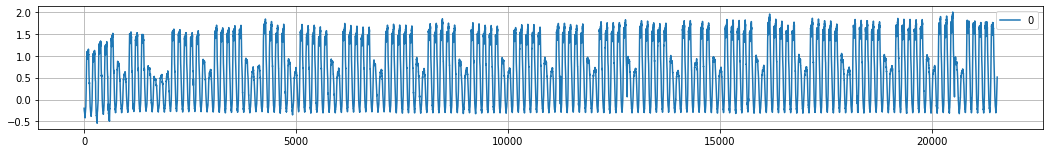

In [63]:
# visualize the common oscillations from the latent space output
pd.DataFrame(model.freqcoder.layers[1].latent(x_train_scaled).numpy()).plot(figsize=(18,2.25), grid=True)

## Results

#### Model outputs

In [64]:
sins, synched, upper, lower = model.predict(x_test_scaled, t_test, batch_size=batch_size*10)

#### Visualize synchronization impact
Synchronization results in increasing multicolinearity, thus reducing the amount of information and the size dimensionality of the latent space

Text(0.5, 1.0, 'After Synchronization')

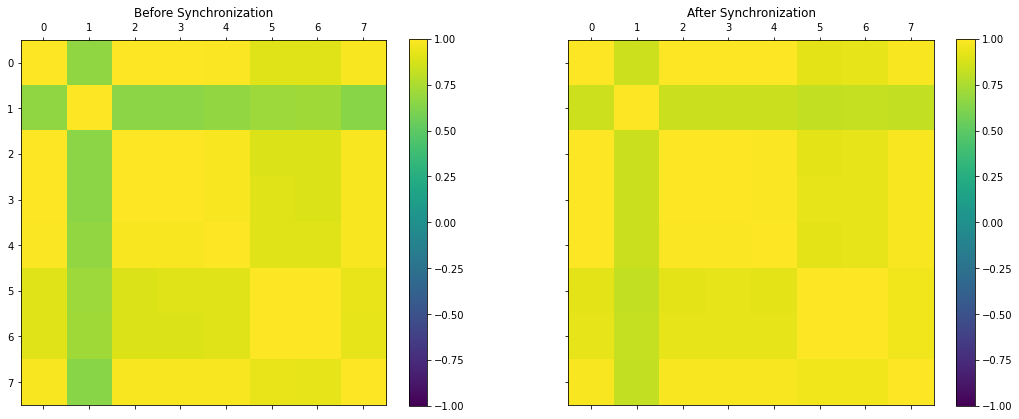

In [65]:
# Get transformed signal
x_test_synched = pd.DataFrame(synched, index=x_test.index, columns=x_test.columns)

# Compare correlation matriices
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(18,6.75))
corr0=ax1.matshow(pd.DataFrame(x_test_scaled).corr(), vmin=-1, vmax=1)
fig.colorbar(corr0, ax=ax1)
ax1.set_title('Before Synchronization')
corr1=ax2.matshow(x_test_synched.corr(), vmin=-1, vmax=1)
fig.colorbar(corr1, ax=ax2)
ax2.set_title('After Synchronization')

### Accuracy evaluation

In [68]:
synched_tiles = np.tile(synched.reshape(synched.shape[0], 1, synched.shape[1]), (1, N, 1))
result = np.where((synched_tiles < lower) | (synched_tiles > upper), 1, 0)
anomaly_scores = np.mean(np.mean(result, axis=1), axis=1)

#### Time-series aware $F1_{best}$

In [ ]:
test_scores = compute_metrics(anomaly_scores, y_test, y_segment_test)

#### $F1_{best}$

In [ ]:
t, th = bf_search(inference.reshape(-1,1), y_test.values, start=0., end=0.9, step_num=int((0.9-0.)/0.0001), display_freq=5000)

F1 = 0.9407402258969699  
Precision = 0.9917708565620501  
Recall = 0.8947130958965124  

#### ${F1^*}_{blind}$

In [ ]:
split = int(inference.shape[0]/2)
inference_test, labels_test = inference[split:], y_test.values[split:]
inference_val, labels_val = inference[:split], y_test.values[:split]
t, th = blind_bf_search(
    inference_test.reshape(-1,1), 
    labels_test, 
    (inference_val.reshape(-1,1), labels_val), 
    start=0., 
    end=0.9, 
    step_num=int((0.9-0.)/0.0001), 
    display_freq=5000, 
    tw=15  # rolling time window
)

F1 = 0.727851385106576  
Precision = 0.8915094199448205  
Recall = 0.6149674553691166  

#### $F1_{init}$

In [ ]:
calc_twseq(inference.reshape(-1,1), y_test.values, 0, 0.5, 15)

F1 = 0.7086926983984027   
Precision = 0.9883474471573364  
Recall = 0.5523978652907172

#### ${F1^*}_{init}$

In [ ]:
calc_seq(inference.reshape(-1,1), y_test.values, 0.5, pred=inference.reshape(-1,1)>0.5)

F1 = 0.8013699329548061  
Precision = 0.9980432915506645    
Recall = 0.66945572344470872  

## Inspection

### Localization
If meta-attributes are available (Ideal), localization can be performed at the attribute level as following:

$loc(attr)=\frac{\sum _{i}\sum_{n}P(i_n|attr_i)}{n\sum _{i}attr_i}$

Where $attr$ is the attribute, $i$ is the index of the feature, $n$ is the index of the encoder, and $P(i_n)$ is the detection result of the $n$th decoders for feature $i$.

For feature-based localization (without meta-attributes), The following expression is used for localization:

$loc(i)=\frac{\sum_{i}\sum_{n}P(i_n)}{n}$

In this notebook's example, we are not providing feature meta-attributes, thus we show examples of using the latter method below:

In [21]:
loc = pd.DataFrame(np.sum(result, axis=1) / N, index=x_test.index, columns=x_test.columns)

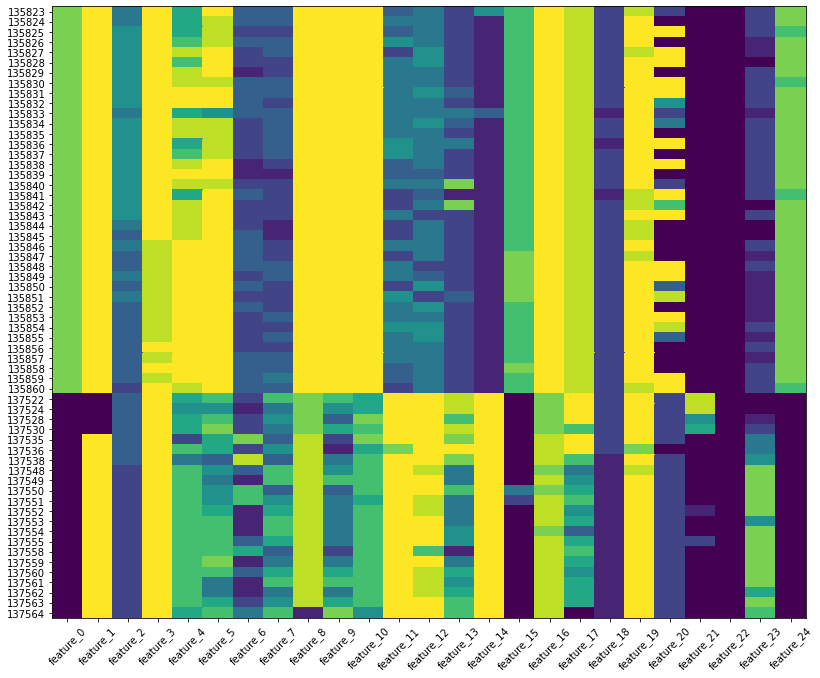

In [22]:
# sample of first 60 alerts:
sample = loc[inference>0.5].iloc[:60]

plt.figure(figsize=(13.5,11.25))
plt.gca().invert_yaxis()
plot = plt.pcolor(sample, vmin=0, vmax=1)
plot = plt.yticks(np.arange(0.5, sample.shape[0], 1), sample.index.astype(int))
plot = plt.xticks(np.arange(0.5, sample.shape[1], 1), sample.columns, rotation=45)

Plot shows 2 separate detected periods of anomalies, first period is from 125823 to 135860 with features (5, 8, 9, 10, 15, and 21) having the strongest localization score, while the 2nd period starts at 137470 and shows features (3, 18, and 21) as the strongest contributors 

### Interpretable visualizations
Inspect a given feature $i$ against its $N$ decoder pairs:

Individual plots for feature_15


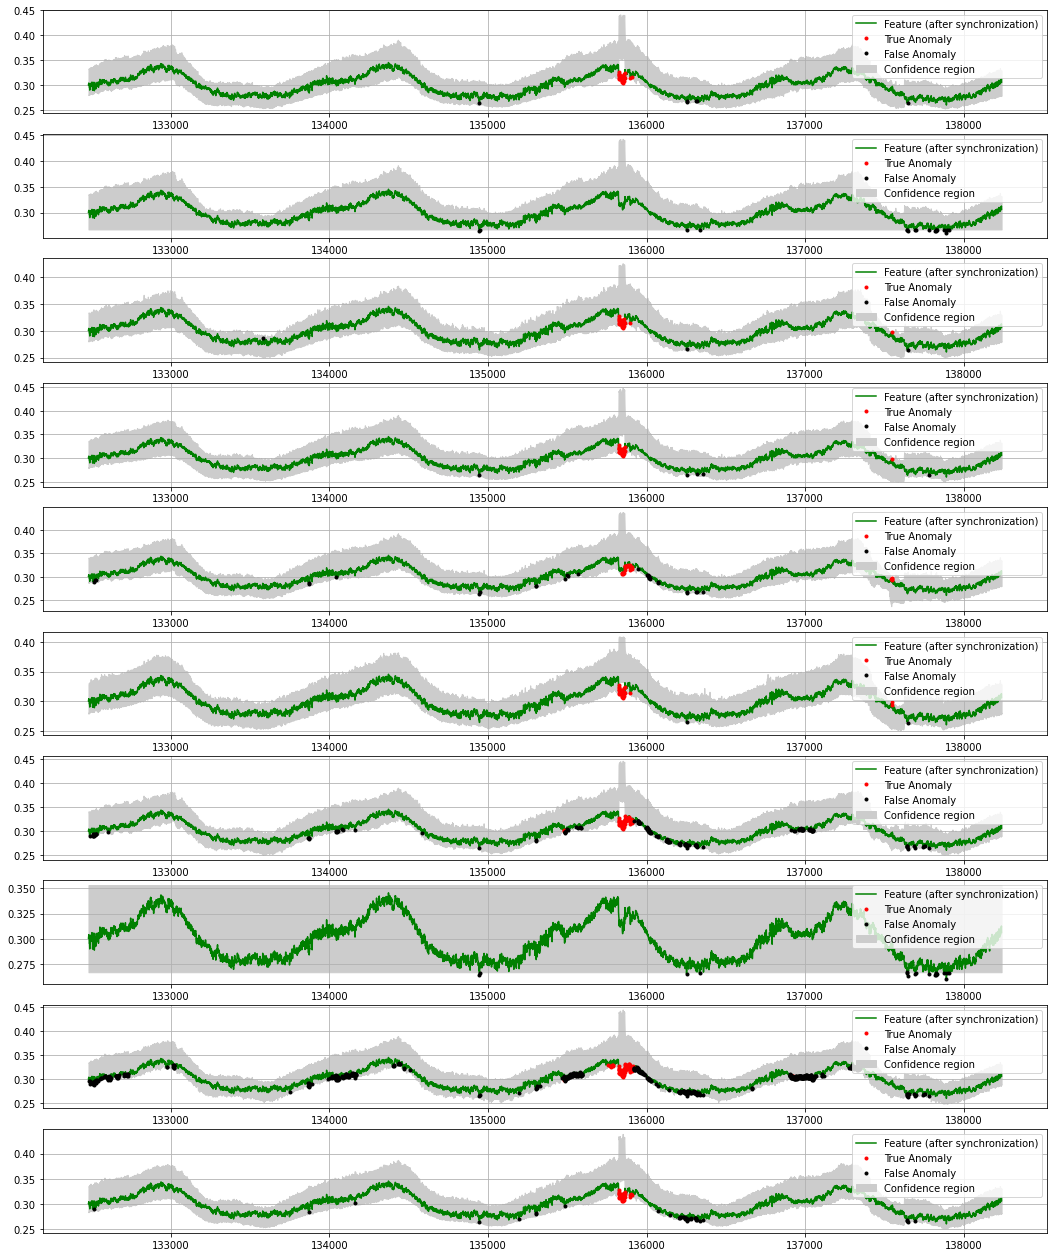

In [23]:
i = 15
tw = 5760  # period to plot (5760 minutes = 4 days)
plt.figure(figsize=(18,22.5))
print(f'Individual plots for feature_{i}')
for n in range(N):
    sample_i = pd.Series(synched_tiles[:,n,i], index=x_test.index.astype(int))[:tw]
    upper_i =  pd.Series(upper[:,n,i], index=x_test.index.astype(int))[:tw]
    lower_i =  pd.Series(lower[:,n,i], index=x_test.index.astype(int))[:tw]
    plt.subplot(N,1,n+1)
    plt.plot(sample_i, 'g', label='Feature (after synchronization)')
    plt.plot(sample_i.loc[(result[:tw,n,i] ==1) & ((y_test.values[:tw] == 1).reshape(-1))], 'r.', label='True Anomaly')
    plt.plot(sample_i.loc[(result[:tw,n,i] ==1) & ((y_test.values[:tw] == 0).reshape(-1))], 'k.', label='False Anomaly')
    plt.fill_between(sample_i.index, lower_i, upper_i, color='0.8', label='Confidence region')
    plt.legend()
    plt.grid()

Alternatively, a plot can be generated on the ensembled results:

Text(0.5, 1.0, 'Ensembled pLot')

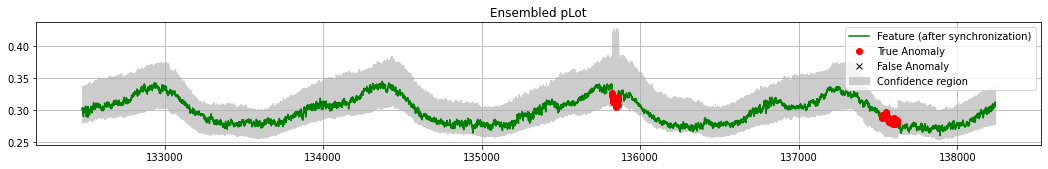

In [24]:
sample_i = pd.Series(synched[:,i], index=x_test.index.astype(int))[:tw]
upper_i =  pd.Series(np.mean(upper[:,:,i], axis=1), index=x_test.index.astype(int))[:tw]
lower_i =  pd.Series(np.mean(lower[:,:,i], axis=1), index=x_test.index.astype(int))[:tw]
plt.figure(figsize=(18,2.25))
plt.plot(sample_i, 'g', label='Feature (after synchronization)')
plt.plot(sample_i.loc[(inference[:tw] > 0.5) & ((y_test.values[:tw] == 1).reshape(-1))], 'ro', label='True Anomaly')
plt.plot(sample_i.loc[(inference[:tw] > 0.5)  & ((y_test.values[:tw] == 0).reshape(-1))], 'kx', label='False Anomaly')
plt.fill_between(sample_i.index, lower_i, upper_i, color='0.8', label='Confidence region')
plt.legend()
plt.grid()
plt.title('Ensembled pLot')

## More about Interpretation and Localization

In [25]:
# Load saved model
model = RANSynCoders.load('example_model.z')

### Interpreting result in initial scale and representation
Practically, some users might be interested in assessing anomalies and estimated values in their raw respresentation (scale and phase). This can be done by turning on the *desync* parameter in the *predict* method:

In [26]:
sins, synched, upper, lower = model.predict(x_test_scaled, t_test, batch_size=batch_size*10, desync=True)

In [27]:
# get inference (using initial representation)
tiles = np.tile(x_test_scaled.reshape(x_test_scaled.shape[0], 1, x_test_scaled.shape[1]), (1, N, 1))
result = np.where((tiles < lower) | (tiles > upper), 1, 0)
inference = np.mean(np.mean(result, axis=1), axis=1)

In [28]:
# inverse scale of the bounds:
n_features = x_test_scaled.shape[1]
upper_inv = xscaler.inverse_transform(upper.reshape(-1, n_features)).reshape(-1, N, n_features)
lower_inv = xscaler.inverse_transform(lower.reshape(-1, n_features)).reshape(-1, N, n_features)

Individual plots for feature_15


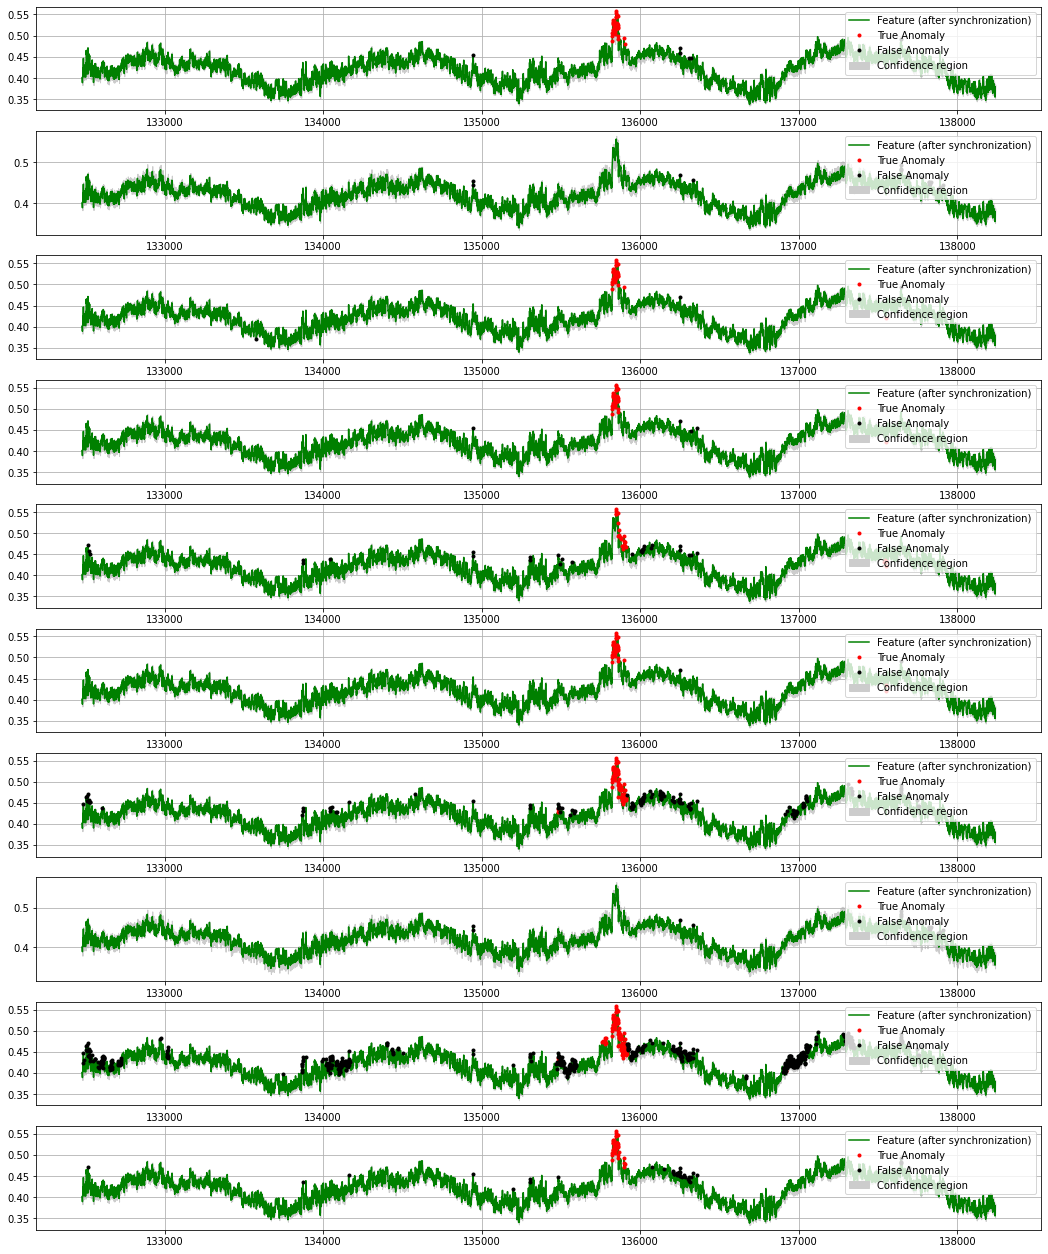

In [29]:
# Visualize model output now in original representation 
i = 15
tw = 5760  # period to plot (5760 minutes = 4 days)
plt.figure(figsize=(18,22.5))
print(f'Individual plots for feature_{i}')
for n in range(N):
    sample_i = pd.Series(x_test.iloc[:,i].values, index=x_test.index.astype(int))[:tw]
    upper_i =  pd.Series(upper_inv[:,n,i], index=x_test.index.astype(int))[:tw]
    lower_i =  pd.Series(lower_inv[:,n,i], index=x_test.index.astype(int))[:tw]
    plt.subplot(N,1,n+1)
    plt.plot(sample_i, 'g', label='Feature (after synchronization)')
    plt.plot(sample_i.loc[(result[:tw,n,i] ==1) & ((y_test.values[:tw] == 1).reshape(-1))], 'r.', label='True Anomaly')
    plt.plot(sample_i.loc[(result[:tw,n,i] ==1) & ((y_test.values[:tw] == 0).reshape(-1))], 'k.', label='False Anomaly')
    plt.fill_between(sample_i.index, lower_i, upper_i, color='0.8', label='Confidence region')
    plt.legend()
    plt.grid()

Alternatively, a plot can be generated on the ensembled results:

Text(0.5, 1.0, 'Ensembled pLot')

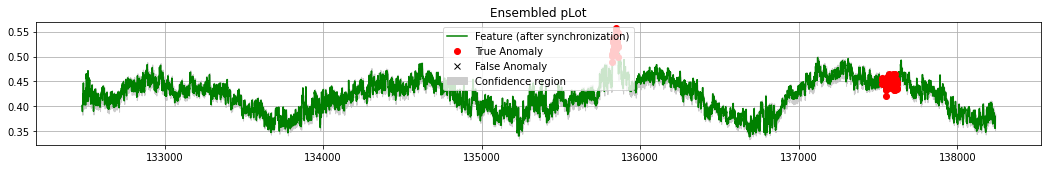

In [30]:
sample_i = pd.Series(x_test.iloc[:,i].values, index=x_test.index.astype(int))[:tw]
upper_i =  pd.Series(np.mean(upper_inv[:,:,i], axis=1), index=x_test.index.astype(int))[:tw]
lower_i =  pd.Series(np.mean(lower_inv[:,:,i], axis=1), index=x_test.index.astype(int))[:tw]
plt.figure(figsize=(18,2.25))
plt.plot(sample_i, 'g', label='Feature (after synchronization)')
plt.plot(sample_i.loc[(inference[:tw] > 0.5) & ((y_test.values[:tw] == 1).reshape(-1))], 'ro', label='True Anomaly')
plt.plot(sample_i.loc[(inference[:tw] > 0.5)  & ((y_test.values[:tw] == 0).reshape(-1))], 'kx', label='False Anomaly')
plt.fill_between(sample_i.index, lower_i, upper_i, color='0.8', label='Confidence region')
plt.legend()
plt.grid()
plt.title('Ensembled pLot')

To inspect the bounds closely:

Text(0.5, 1.0, 'Ensembled pLot')

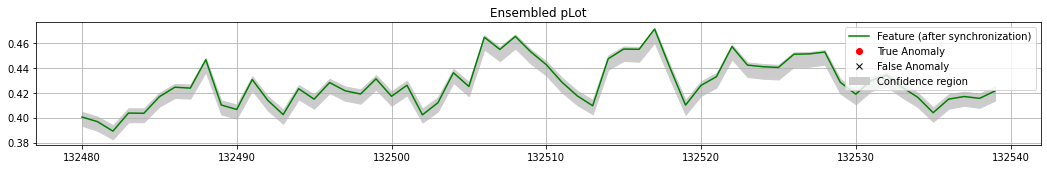

In [31]:
# plot only first 60 intervals:
tw2 = 60
sample_i = pd.Series(x_test.iloc[:,i].values, index=x_test.index.astype(int))[:tw2]
upper_i =  pd.Series(np.mean(upper_inv[:,:,i], axis=1), index=x_test.index.astype(int))[:tw2]
lower_i =  pd.Series(np.mean(lower_inv[:,:,i], axis=1), index=x_test.index.astype(int))[:tw2]
plt.figure(figsize=(18,2.25))
plt.plot(sample_i, 'g', label='Feature (after synchronization)')
plt.plot(sample_i.loc[(inference[:tw2] > 0.5) & ((y_test.values[:tw2] == 1).reshape(-1))], 'ro', label='True Anomaly')
plt.plot(sample_i.loc[(inference[:tw2] > 0.5)  & ((y_test.values[:tw2] == 0).reshape(-1))], 'kx', label='False Anomaly')
plt.fill_between(sample_i.index, lower_i, upper_i, color='0.8', label='Confidence region')
plt.legend()
plt.grid()
plt.title('Ensembled pLot')